In [54]:
import numpy as np
import pandas as pd
import tables
from glob import glob
from os.path import join, exists
import matplotlib as mpl
from matplotlib import pyplot as plt
import re
from sstcam_simulation import Camera
from scipy.signal import find_peaks, peak_widths
from sstcam_simulation.performance.plot_lab_performance import extract_charge_resolution_mc, extract_trigger_efficiency
from tqdm.auto import tqdm
from CHECLabPy.plotting.resolutions import ChargeResolutionPlotter
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.interpolate import griddata
%matplotlib inline

In [69]:
with pd.HDFStore("performance.h5", mode='r') as store:
    df_data = store['data']

df_data = df_data.loc[(df_data['pulse_width'] <= 17) & (df_data['undershoot_width'] <= 29)]
df_data = df_data.loc[df_data['ratio'] != 0.6]

In [70]:
# Extract requirements
true = np.geomspace(1, 1000)
crreq = ChargeResolutionPlotter.requirement(true)
crreq_2pe = np.interp(2, true, crreq)
crreq_100pe = np.interp(100, true, crreq)
print(crreq_2pe, crreq_100pe)

checs_ratio = 0.20581828565154767
checs_pulse_width = 10.650883938789999
checs_undershoot_width = 19.880996171267505

1.1809228716436992 0.1572348562845242


# 20% Undershoot

In [71]:
df = df_data.loc[df_data['ratio'] == 0.2]

In [72]:
df.iloc[194]

ratio                0.200000
sigma0               3.190000
sigma1               4.290000
pulse_width          7.685265
undershoot_width    17.107780
teff_50              4.395590
cr_2pe               1.179492
cr_100pe             0.126235
Name: 1192, dtype: float64

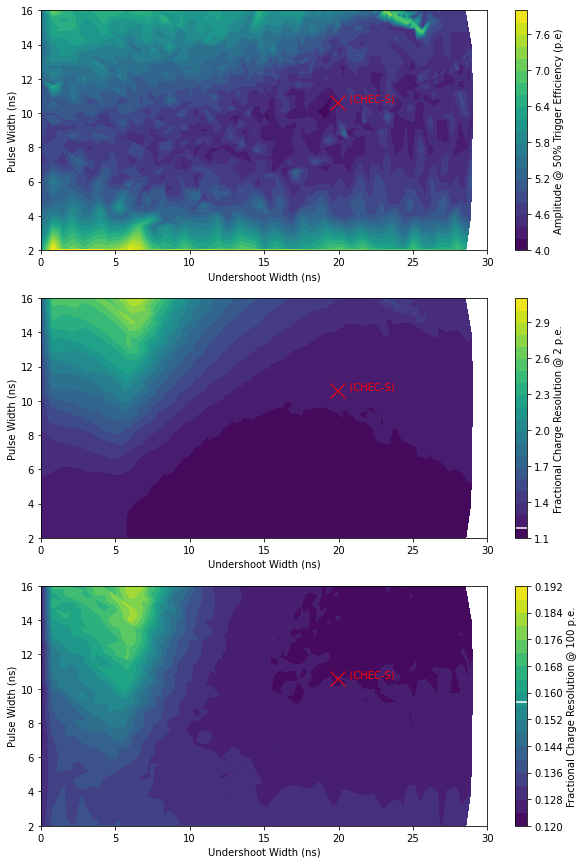

In [73]:
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

def plot(ax, z, z_label, req=None):
    c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df[z], 20)
    #ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
    ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
    ax.text(checs_undershoot_width, checs_pulse_width, "    (CHEC-S)", color='red')
    ax.set_xlabel("Undershoot Width (ns)")
    ax.set_ylabel("Pulse Width (ns)")
    ax.set_xlim(0, 30)
    ax.set_ylim(ymax=16)
    cb = fig.colorbar(c, ax=ax, label=z_label)
    cb.ax.plot([0, 10], [req, req], 'w-')

plot(ax1, 'teff_50', "Amplitude @ 50% Trigger Efficiency (p.e)")
plot(ax2, 'cr_2pe', "Fractional Charge Resolution @ 2 p.e.", crreq_2pe)
plot(ax3, 'cr_100pe', "Fractional Charge Resolution @ 100 p.e.", crreq_100pe)

plt.savefig("tricontourf.png", dpi=300)

In [61]:
def regular_grid_interp(df, n_undershoot, n_pulse):
    xi = np.linspace(df['undershoot_width'].min(), df['undershoot_width'].max(), n_undershoot)
    yi = np.linspace(df['pulse_width'].min(), df['pulse_width'].max(), n_pulse)
    Xi, Yi = np.meshgrid(xi, yi)
    Zi_teff_50 = griddata((df['undershoot_width'], df['pulse_width']), df['teff_50'], (Xi, Yi))
    Zi_cr_2pe = griddata((df['undershoot_width'], df['pulse_width']), df['cr_2pe'], (Xi, Yi))
    Zi_cr_100pe = griddata((df['undershoot_width'], df['pulse_width']), df['cr_100pe'], (Xi, Yi))
    df_interp = pd.DataFrame(dict(
        undershoot_width=Xi.ravel(),
        pulse_width=Yi.ravel(),
        teff_50=Zi_teff_50.ravel(),
        cr_2pe=Zi_cr_2pe.ravel(),
        cr_100pe=Zi_cr_100pe.ravel(),
    ))
    return df_interp.dropna()

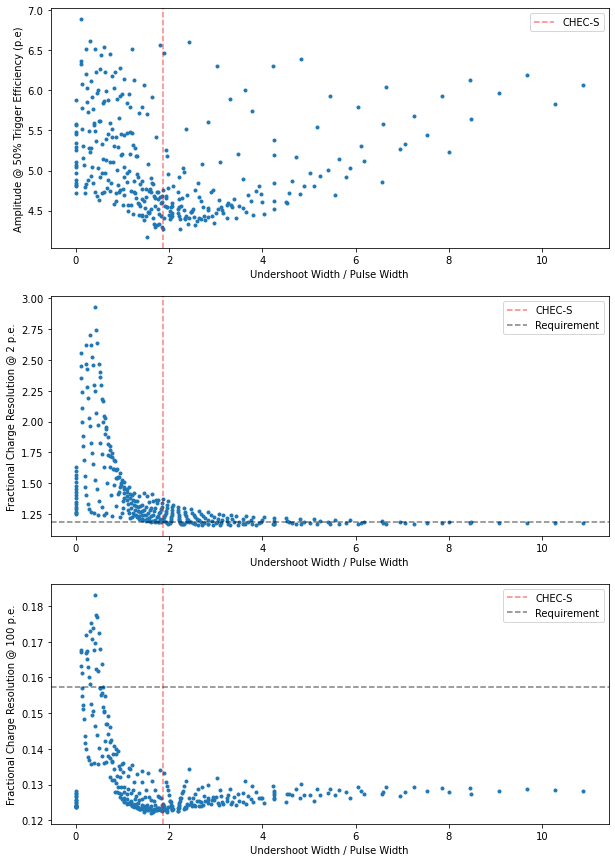

In [62]:
df_interp = regular_grid_interp(df, 20, 20)
df_interp['width_ratio'] = df_interp['undershoot_width'] / df_interp['pulse_width']

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

def plot(ax, y, y_label, req=None):
    #ax.hist2d(df_interp['width_ratio'], df_interp[y], bins=(40, 40))
    ax.plot(df_interp['width_ratio'], df_interp[y], '.')
    ax.axvline(checs_undershoot_width/checs_pulse_width, ls='--', color='r', alpha=0.5, label="CHEC-S")
    if req:
        ax.axhline(req, ls='--', color='black', alpha=0.5, label="Requirement")
    ax.set_xlabel("Undershoot Width / Pulse Width")
    ax.set_ylabel(y_label)
    #fig.colorbar(c, ax=ax, label="N")
    ax.legend(loc=1)

plot(ax1, 'teff_50', "Amplitude @ 50% Trigger Efficiency (p.e)")
plot(ax2, 'cr_2pe', "Fractional Charge Resolution @ 2 p.e.", crreq_2pe)
plot(ax3, 'cr_100pe', "Fractional Charge Resolution @ 100 p.e.", crreq_100pe)

plt.savefig("width_ratio.png", dpi=300)

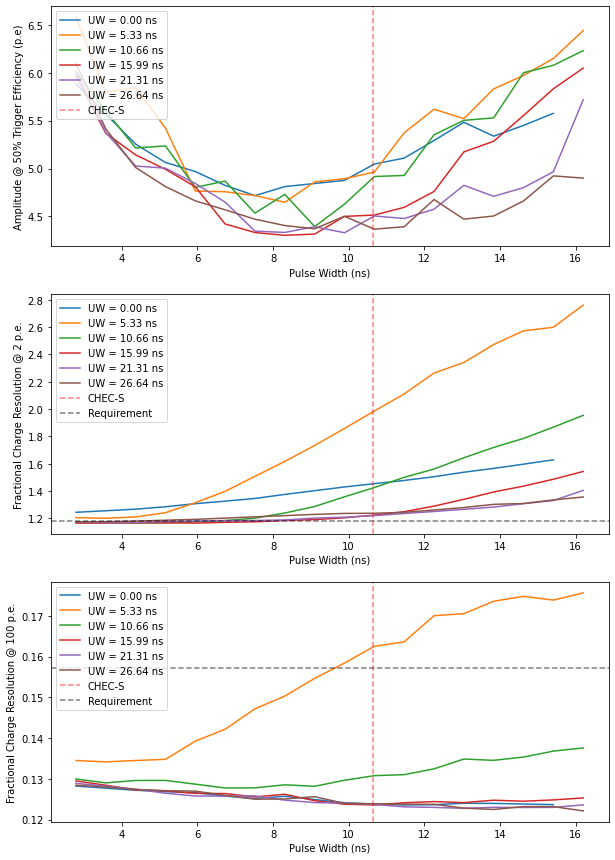

In [63]:
df_interp = regular_grid_interp(df, 7, 20)

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

def plot(ax, y, y_label, req=None):
    for undershoot_width, group in df_interp.groupby('undershoot_width'):
        ax.plot(group['pulse_width'], group[y], label=f"UW = {undershoot_width:.2f} ns")
        
    ax.axvline(checs_pulse_width, ls='--', color='r', alpha=0.5, label="CHEC-S")
    if req:
        ax.axhline(req, ls='--', color='black', alpha=0.5, label="Requirement")
        
    ax.set_xlabel("Pulse Width (ns)")
    ax.set_ylabel(y_label)
    ax.legend(loc=2)

plot(ax1, 'teff_50', "Amplitude @ 50% Trigger Efficiency (p.e)")
plot(ax2, 'cr_2pe', "Fractional Charge Resolution @ 2 p.e.", crreq_2pe)
plot(ax3, 'cr_100pe', "Fractional Charge Resolution @ 100 p.e.", crreq_100pe)

plt.savefig("1d_pulse_width.png", dpi=300)

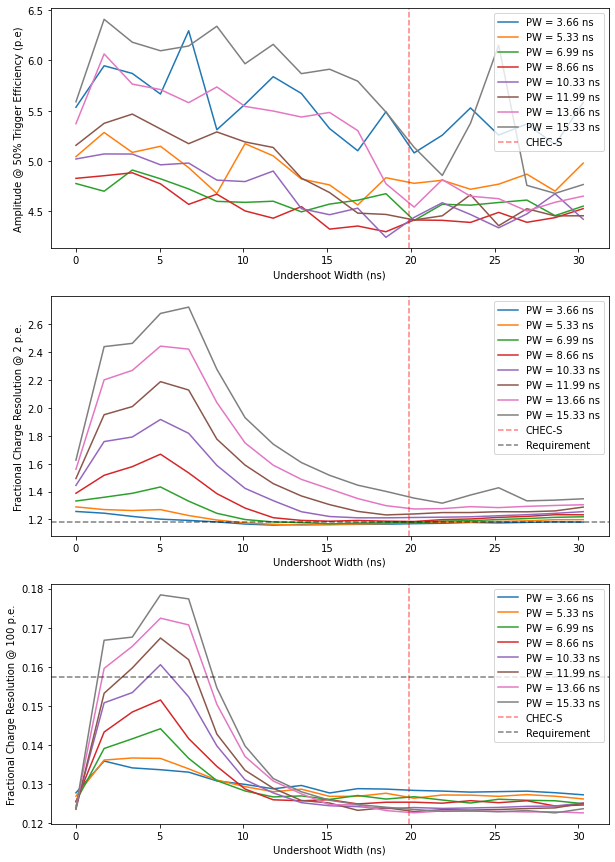

In [64]:
df_interp = regular_grid_interp(df, 20, 10)

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

def plot(ax, y, y_label, req=None):
    for pulse_width, group in df_interp.groupby('pulse_width'):
        ax.plot(group['undershoot_width'], group[y], label=f"PW = {pulse_width:.2f} ns")
        
    ax.axvline(checs_undershoot_width, ls='--', color='r', alpha=0.5, label="CHEC-S")
    if req:
        ax.axhline(req, ls='--', color='black', alpha=0.5, label="Requirement")
        
    ax.set_xlabel("Undershoot Width (ns)")
    ax.set_ylabel(y_label)
    ax.legend(loc='best')

plot(ax1, 'teff_50', "Amplitude @ 50% Trigger Efficiency (p.e)")
plot(ax2, 'cr_2pe', "Fractional Charge Resolution @ 2 p.e.", crreq_2pe)
plot(ax3, 'cr_100pe', "Fractional Charge Resolution @ 100 p.e.", crreq_100pe)

plt.savefig("1d_undershoot_width.png", dpi=300)

# Other Ratios

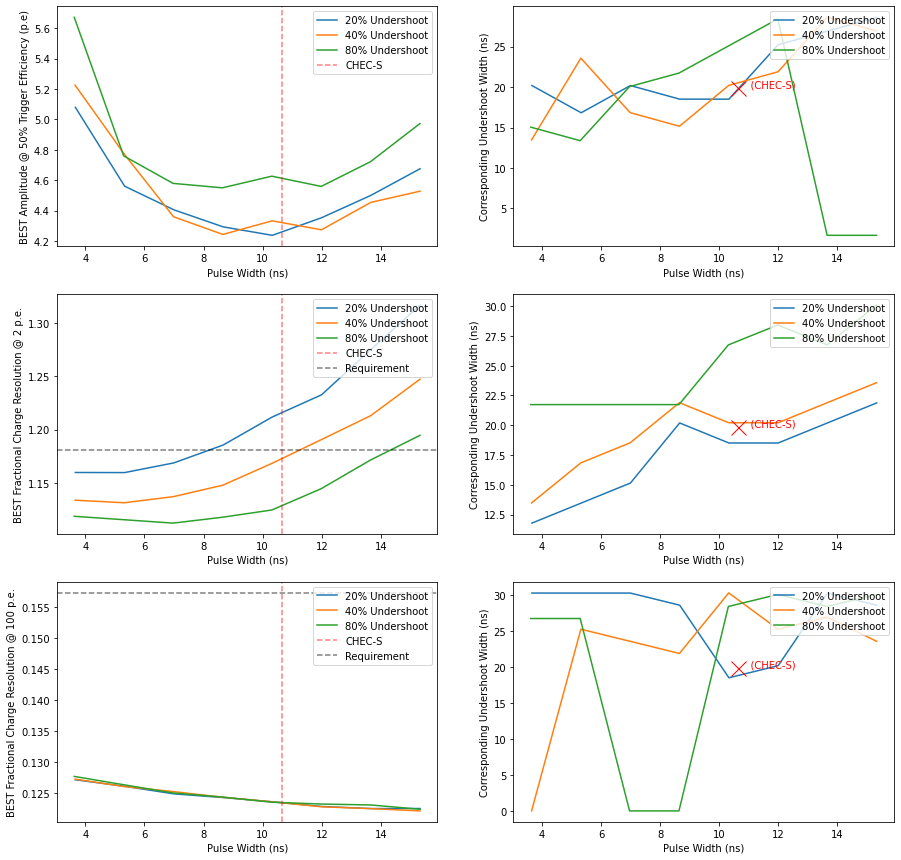

In [65]:
def get_df_best(df, perf):
    df_interp = regular_grid_interp(df, 20, 10)
    df_best = df_interp.loc[df_interp.groupby('pulse_width')[perf].idxmin()]
    return df_best


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

def plot_perf(ax, y, y_label, req=None):
    for ratio, group in df_data.groupby('ratio'):
        ratiop = int(ratio*100)
        df_best = get_df_best(group, y)
        ax.plot(df_best['pulse_width'], df_best[y], label=f"{ratiop}% Undershoot")
    
    ax.axvline(checs_pulse_width, ls='--', color='r', alpha=0.5, label="CHEC-S")
    if req:
        ax.axhline(req, ls='--', color='black', alpha=0.5, label="Requirement")
    
    ax.set_xlabel("Pulse Width (ns)")
    ax.set_ylabel(y_label)
    ax.legend(loc=1)
    
def plot_uw(ax, y, y_label):
    for ratio, group in df_data.groupby('ratio'):
        ratiop = int(ratio*100)
        df_best = get_df_best(group, y)
        ax.plot(df_best['pulse_width'], df_best['undershoot_width'], label=f"{ratiop}% Undershoot")
    
    ax.plot(checs_pulse_width, checs_undershoot_width, 'x', color='red', ms=15)
    ax.text(checs_pulse_width, checs_undershoot_width, "    (CHEC-S)", color='red')
    
    ax.set_xlabel("Pulse Width (ns)")
    ax.set_ylabel("Corresponding Undershoot Width (ns)")
    ax.legend(loc=1)

plot_perf(ax1, 'teff_50', "BEST Amplitude @ 50% Trigger Efficiency (p.e)")
plot_uw(ax2, 'teff_50', "BEST Amplitude @ 50% Trigger Efficiency (p.e)")
plot_perf(ax3, 'cr_2pe', "BEST Fractional Charge Resolution @ 2 p.e.", crreq_2pe)
plot_uw(ax4, 'cr_2pe', "BEST Fractional Charge Resolution @ 2 p.e.")
plot_perf(ax5, 'cr_100pe', "BEST Fractional Charge Resolution @ 100 p.e.", crreq_100pe)
plot_uw(ax6, 'cr_100pe', "BEST Fractional Charge Resolution @ 100 p.e.")

plt.savefig("best.png", dpi=300)